In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from biokit import viz
from biokit.viz import hist2d
import warnings
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA
from configuration import CSV_PATH, cross_valid_len, min_games_cnt
from MyGeniousKNN import MyGeniousKNN as MGKNN

warnings.filterwarnings('ignore')

Репозиторий с 1 ЛР https://github.com/itmo-ml-lab-ML-course/parser-GarnetAki

#### Функции подготовки данных

In [3]:
def open_dataset(path):
    data = pd.read_csv(path, delimiter=',', index_col='Index')
    return data

def delete_emissions(data):
    new_data = data[data["Sher games cnt"] > min_games_cnt]
    new_data = new_data[new_data["1 Maf games cnt"] > min_games_cnt]
    new_data = new_data[new_data["2 Maf games cnt"] > min_games_cnt]
    new_data = new_data[new_data["Don games cnt"] > min_games_cnt]
    new_data = new_data[new_data["Days Number"] > 1.5]
    return new_data

def adapt_str(data):
    data['Win'] = data['Win'].map(lambda x: 1.0 if x == 'Civilian' else 0.0)
    data['Type'] = data['Type'].map(lambda x: 1.0 if x == 'tournament' else 0.5 if x == 'lobby' else 0.0)
    return data

def max_streak(places):
    places.sort()
    streak = 1
    if places[1] == places[0] + 1:
        streak += 1
    if places[2] == places[1] + 1:
        streak += 1
    return streak

def add_features(data):
    dwf = data 
    dwf['Max Maf streak'] = data['Win']
    dwf['Avg Civ avg pts'] = data['Win']
    dwf['Avg Civ games cnt'] = data['Win']
    for i in range(len(dwf)):
        dwf['Max Maf streak'].iloc[i] = max_streak([dwf['First Mafia Place'].iloc[i], dwf['Last Mafia Place'].iloc[i], dwf['Don Place'].iloc[i]])
        dwf['Avg Civ avg pts'].iloc[i] = (dwf['1 Civ avg pts'].iloc[i] + dwf['2 Civ avg pts'].iloc[i] + \
            dwf['3 Civ avg pts'].iloc[i] + dwf['4 Civ avg pts'].iloc[i] + \
            dwf['5 Civ avg pts'].iloc[i] + dwf['6 Civ avg pts'].iloc[i]) / 6
        dwf['Avg Civ games cnt'].iloc[i] = (dwf['1 Civ games cnt'].iloc[i] + dwf['2 Civ games cnt'].iloc[i] + \
            dwf['3 Civ games cnt'].iloc[i] + dwf['4 Civ avg pts'].iloc[i] + \
            dwf['5 Civ games cnt'].iloc[i] + dwf['6 Civ games cnt'].iloc[i]) / 6

    dwf = dwf.drop('1 Civ avg pts', axis=1)
    dwf = dwf.drop('1 Civ games cnt', axis=1)
    dwf = dwf.drop('2 Civ avg pts', axis=1)
    dwf = dwf.drop('2 Civ games cnt', axis=1)
    dwf = dwf.drop('3 Civ avg pts', axis=1)
    dwf = dwf.drop('3 Civ games cnt', axis=1)
    dwf = dwf.drop('4 Civ avg pts', axis=1)
    dwf = dwf.drop('4 Civ games cnt', axis=1)
    dwf = dwf.drop('5 Civ avg pts', axis=1)
    dwf = dwf.drop('5 Civ games cnt', axis=1)
    dwf = dwf.drop('6 Civ avg pts', axis=1)
    dwf = dwf.drop('6 Civ games cnt', axis=1)
    return dwf

def separate_train_test(data):
    return np.split(data, [int(.8*len(data))])

def separate_x_and_y(data):
    x = data.drop('Win', axis=1)
    y = data['Win']
    return x, y

#### Анализ параметров

Загружаю датасет из первой лабараторной работы, удаляю из него "выбросы" - игры, которые закончились за нулевой и первый день (Ненормальная ситуация. Вероятно, в таких играх кого-то не было видно во время договорки и мафия просто вышла/сдалась, чтобы не тянуть время и скорее начать новую игру), а также игры, в которых есть игрок с "активной ролью", который играл за неё менее 5 раз ранее.

In [4]:
full_data = open_dataset(CSV_PATH)
print("All data len:", len(full_data))
processed_data = add_features(adapt_str(delete_emissions(full_data)))
print("Data len after deleting emissions:", len(processed_data))
civ_won_data = processed_data[processed_data['Win'] == 1]
print("Civilian WR:", len(civ_won_data)/len(processed_data))

All data len: 27923
Data len after deleting emissions: 11790
Civilian WR: 0.41000848176420696


##### Графики, по которым можно проверить распределение величин или принадлежность к классу таргета от значений любых двух фич. updated: только интересные пары параметров - наиболее коррелирующие с таргетом - проценты побед игроков на их ролях.

In [5]:
maf_won_data = processed_data[processed_data['Win'] == 0]
h_maf1 = hist2d.Hist2D(maf_won_data['Sher WR'], maf_won_data['1 Maf WR'] + maf_won_data['2 Maf WR']/2)
h_maf2 = hist2d.Hist2D((maf_won_data['1 Civ WR'] + maf_won_data['2 Civ WR'] + maf_won_data['3 Civ WR'] + maf_won_data['4 Civ WR'] + maf_won_data['5 Civ WR'] + maf_won_data['6 Civ WR'])/6, maf_won_data['1 Maf WR'] + maf_won_data['2 Maf WR']/2)
h_civ1 = hist2d.Hist2D(civ_won_data['Sher WR'], civ_won_data['1 Maf WR'] + civ_won_data['2 Maf WR']/2)
h_civ2 = hist2d.Hist2D((civ_won_data['1 Civ WR'] + civ_won_data['2 Civ WR'] + civ_won_data['3 Civ WR'] + civ_won_data['4 Civ WR'] + civ_won_data['5 Civ WR'] + civ_won_data['6 Civ WR'])/6, civ_won_data['1 Maf WR'] + civ_won_data['2 Maf WR']/2)

###### Победа мафии:

Mafia win games statistic


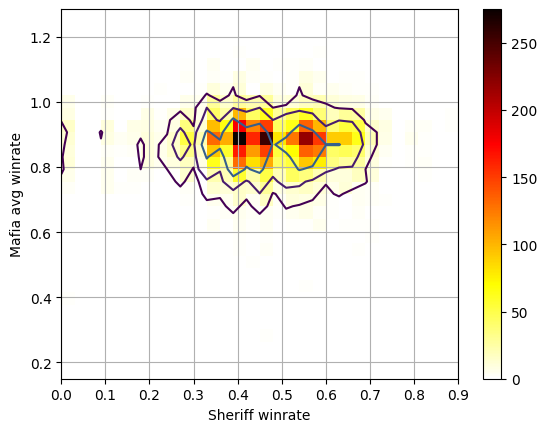

In [6]:
print('Mafia win games statistic')
res_maf = h_maf1.plot(bins=[30,30], contour=True, nnorm='log', Nlevels=6, xlabel='Sheriff winrate', ylabel='Mafia avg winrate')

Mafia win games statistic


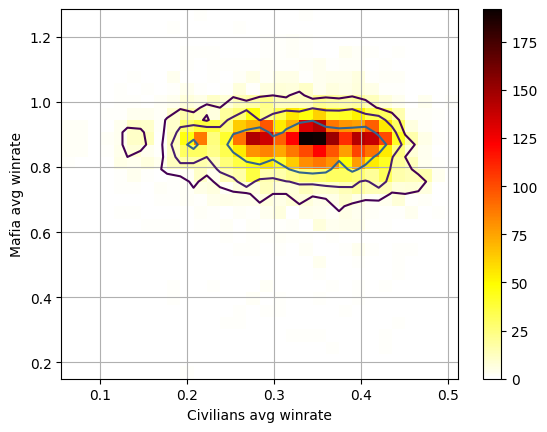

In [7]:
print('Mafia win games statistic')
res_maf2 = h_maf2.plot(bins=[30,30], contour=True, nnorm='log', Nlevels=6, xlabel='Civilians avg winrate', ylabel='Mafia avg winrate')

###### Победа мирных:

Civilian win games statistic


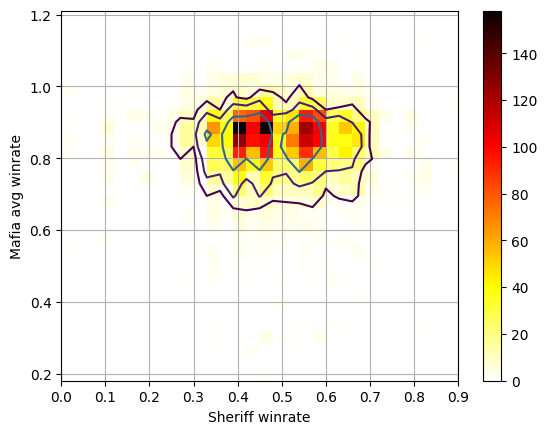

In [8]:
print('Civilian win games statistic')
res_civ = h_civ1.plot(bins=[30,30], contour=True, nnorm='log', Nlevels=6, xlabel='Sheriff winrate', ylabel='Mafia avg winrate')

Civilian win games statistic


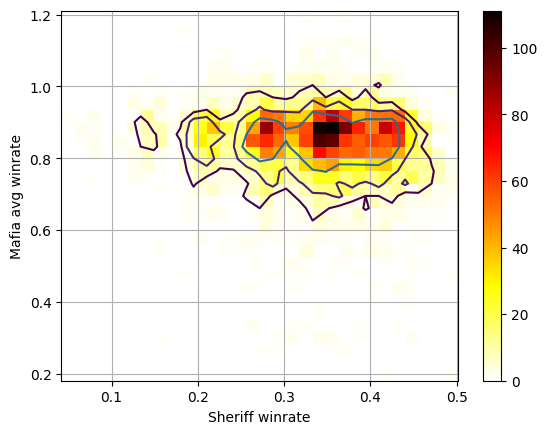

In [9]:
print('Civilian win games statistic')
res_civ2 = h_civ2.plot(bins=[30,30], contour=True, nnorm='log', Nlevels=6, xlabel='Sheriff winrate', ylabel='Mafia avg winrate')

###### Распределения некоторых величин

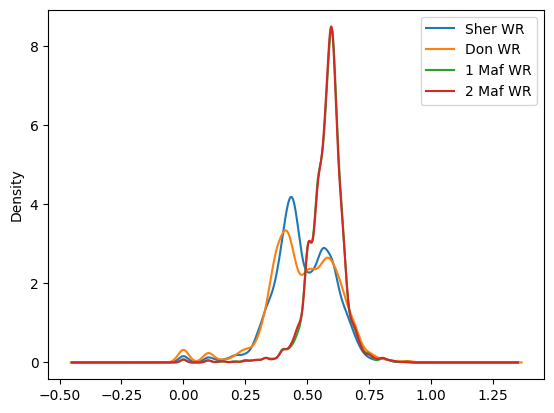

In [39]:
processed_data['Sher WR'].plot.kde().legend()
processed_data['Don WR'].plot.kde().legend()
processed_data['1 Maf WR'].plot.kde().legend()
processed_data['2 Maf WR'].plot.kde().legend()

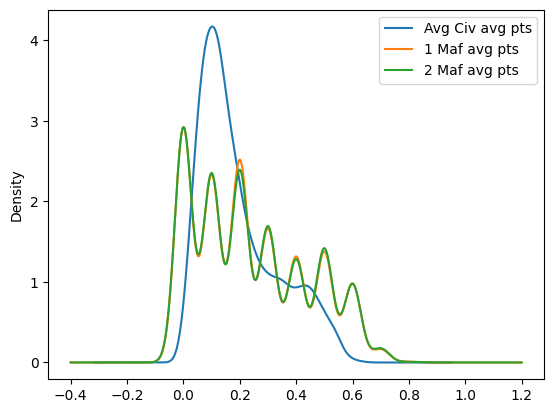

In [42]:
processed_data['Avg Civ avg pts'].plot.kde().legend()
processed_data['1 Maf avg pts'].plot.kde().legend()
processed_data['2 Maf avg pts'].plot.kde().legend()

##### Попарная корреляция:

Анализируя таблицу корреляции, самыми влияющими на результат игры показателями являются проценты побед игроков, которым достались "активные" роли на этих самых ролях и количество дней в игре. Но так как количество дней не детерменировано в начале игры, этот показатель использоваться в качестве фичи не будет.

In [10]:
corr = processed_data.corr()
corr.style.background_gradient(cmap='coolwarm')

,Type,Win,Days Number,Sheriff Place,Don Place,First Mafia Place,Last Mafia Place,1 Civ WR,2 Civ WR,3 Civ WR,4 Civ WR,5 Civ WR,6 Civ WR,Sher WR,1 Maf WR,2 Maf WR,Don WR,Sher games cnt,1 Maf games cnt,2 Maf games cnt,Don games cnt,Sher avg pts,1 Maf avg pts,2 Maf avg pts,Don avg pts,Max Maf streak,Avg Civ avg pts,Avg Civ games cnt
Type,1.000000,0.024520,0.003276,-0.014518,0.005235,0.002665,-0.002398,0.015285,0.033539,0.020051,0.031670,0.030922,0.026521,0.064197,-0.044360,-0.056696,-0.009102,-0.071126,-0.072377,-0.075445,-0.073810,0.566812,0.580358,0.595502,0.588334,0.007166,0.669577,-0.140315
Win,0.024520,1.000000,0.269493,-0.002623,-0.000991,-0.007296,0.013642,0.016572,0.028695,0.023080,0.022555,0.019812,0.028598,0.080923,-0.124819,-0.121037,-0.038388,0.046856,-0.011668,-0.013980,-0.020799,0.051618,-0.023738,-0.019832,-0.006067,-0.009330,0.053235,0.049457
Days Number,0.003276,0.269493,1.000000,0.007820,-0.004932,0.011557,0.004649,0.007492,0.019700,0.010201,0.014141,0.013246,0.021552,0.011148,-0.035504,-0.034389,-0.028708,0.000770,-0.025718,-0.019679,-0.029681,0.004588,-0.014693,-0.004736,-0.030671,0.017081,0.019269,-0.001189
Sheriff Place,-0.014518,-0.002623,0.007820,1.000000,-0.117991,-0.140109,-0.141246,0.001784,-0.002332,-0.015740,-0.006860,-0.003802,-0.004561,0.002562,-0.007011,-0.001626,0.001009,-0.004686,0.020317,0.005808,0.020501,-0.007495,-0.004710,-0.014771,-0.010043,-0.014251,-0.020288,0.002964
Don Place,0.005235,-0.000991,-0.004932,-0.117991,1.000000,-0.138060,-0.155396,-0.007463,0.010466,0.004647,0.006903,0.020273,0.001417,-0.004762,0.009032,-0.002006,-0.007858,-0.006698,-0.026777,-0.002869,-0.023476,0.005660,0.009161,0.000381,0.001094,0.010238,0.014376,-0.003371
First Mafia Place,0.002665,-0.007296,0.011557,-0.140109,-0.138060,1.000000,0.502670,0.004960,-0.007499,0.002430,0.009615,-0.008732,-0.002581,0.002301,-0.004048,-0.004222,-0.003015,0.010052,-0.012573,0.005762,-0.009164,-0.008595,-0.000319,0.002696,0.002375,0.200084,0.003456,0.018617
Last Mafia Place,-0.002398,0.013642,0.004649,-0.141246,-0.155396,0.502670,1.000000,-0.005430,0.004737,0.004368,0.001981,0.008462,-0.002650,0.004687,0.002828,0.008382,0.008931,0.002445,-0.002299,0.016880,-0.003949,-0.015875,-0.017753,-0.001134,0.003216,-0.149850,-0.008652,0.010522
1 Civ WR,0.015285,0.016572,0.007492,0.001784,-0.007463,0.004960,-0.005430,1.000000,0.029690,0.021658,0.011851,0.028281,0.018145,0.001326,-0.016283,-0.020931,-0.017883,-0.021761,-0.021072,-0.036964,-0.023146,0.034057,0.035339,0.030355,0.032905,-0.003981,0.182222,0.150944
2 Civ WR,0.033539,0.028695,0.019700,-0.002332,0.010466,-0.007499,0.004737,0.029690,1.000000,0.007953,0.030636,0.023546,0.021374,0.008309,-0.023058,-0.031812,-0.016435,-0.009795,-0.004930,-0.014601,-0.035925,0.038434,0.032066,0.046076,0.037981,-0.000411,0.192470,0.151266
3 Civ WR,0.020051,0.023080,0.010201,-0.015740,0.004647,0.002430,0.004368,0.021658,0.007953,1.000000,0.005859,0.018858,0.010416,0.003103,-0.015896,-0.014419,0.016493,-0.016294,-0.023541,-0.029623,-0.022778,0.042751,0.029848,0.043543,0.040330,0.005051,0.184822,0.147907


#### Работа модели из библиотеки

С помощью кросс-валидации нахожу лучший k. При этом нормализую данные, чтобы функция расстояния была равноценна для всех фич.

In [11]:
def cross_valid(k, data):
    accuracy = []
    for i in range(cross_valid_len):
        train_data, val_data = separate_train_val_dec(data, i)
        x_train, y_train = separate_x_and_y(train_data)
        x_val, y_val = separate_x_and_y(val_data)
        knn = KNeighborsClassifier(n_neighbors=k)
        knn_model = knn.fit(x_train, y_train)
        knn_predictions = knn.predict(x_val)
        accuracy.append(accuracy_score(y_val, knn_predictions))
    return np.sum(accuracy) / cross_valid_len

def my_cross_valid(k, data):
    accuracy = []
    for i in range(cross_valid_len):
        train_data, val_data = separate_train_val_dec(data, i)
        x_train, y_train = separate_x_and_y(train_data)
        x_val, y_val = separate_x_and_y(val_data)
        knn = MGKNN(k=k)
        knn = knn.fit(x_train, y_train)
        knn_predictions = knn.predict(x_val)
        accuracy.append(knn.accuracy(y_val, knn_predictions))
    return np.sum(accuracy) / cross_valid_len

def separate_train_val_dec(data, x):
    if x == 0:
        data1, data2 = np.split(data, [int((1 / cross_valid_len) * len(data))])
        return data2, data1
    
    if x == cross_valid_len - 1:
        data1, data2 = np.split(data, [int(((cross_valid_len - 1) / cross_valid_len) * len(data))])
        return data1, data2

    data1, data2, data3 = np.split(data, [int((1 / cross_valid_len) * x * len(data)), int((1 / cross_valid_len) * (x + 1) * len(data))])
    return pd.concat([data1, data3], axis=0), data2

def norm_data(data: pd.DataFrame):
    new_data = data
    new_data = new_data.drop('Days Number', axis=1)
    for column in tqdm(new_data.columns):
        min_el = 1
        if column[-1] == 'e' and column[-2] == 'c':
            new_data[column] = new_data[column].map(lambda x: (x - min_el) / 9)

        if column[-1] == 'k':
            new_data[column] = new_data[column].map(lambda x: (x - min_el) / 2)

        if column[-1] == 't':
            max_el = new_data[column].max()
            new_data[column] = new_data[column].map(lambda x: (x + 1 - min_el) / (max_el + 1 - min_el))

    return new_data

In [12]:
processed_data = norm_data(processed_data)
train_data, test_data = separate_train_test(processed_data)
x_test, y_test = separate_x_and_y(test_data)
print("Train data len:", len(train_data))
print("Test data len:", len(test_data))

100%|██████████| 27/27 [00:00<00:00, 1424.70it/s]

Train data len: 9432
Test data len: 2358


In [13]:
lib_acc_result = []
for k in range(1, 200):
    lib_acc_result.append([k, cross_valid(k, test_data)])

lib_acc_result.sort(key=lambda x: x[1], reverse=True)
print("Best trained lib model [k, val accuracy]:", lib_acc_result[0])

k = lib_acc_result[0][0]
knn = KNeighborsClassifier(n_neighbors=k)
train_x, train_y = separate_x_and_y(train_data)
knn_model = knn.fit(train_x, train_y)
knn_predictions = knn.predict(x_test)
accuracy = accuracy_score(y_test, knn_predictions)
print("Test accuracy:", accuracy)

Best trained lib model [k, val accuracy]: [149, 0.5606238730616662]
Test accuracy: 0.5631891433418151


#### Работа моей модели 

Так как алгоритм детерминирован на одном и том же наборе данных (с точностью до k-го соседа, который может отличаться при равном расстоянии с k+1 соседом), а моя реализация работает медленно, использую тот же k, который подобрала кросс-валидация на библиотечной модели.

In [14]:
my_knn = MGKNN(k=k)
my_knn = my_knn.fit(train_x, train_y)
my_knn_predictions = my_knn.predict(x_test)
my_accuracy = my_knn.accuracy(y_test, my_knn_predictions)
print("Test accuracy:", my_accuracy)

100%|██████████| 2358/2358 [43:21<00:00,  1.10s/it] 

Test accuracy: 0.5631891433418151


Accuracy на моей модели и на модели из библиотеки совпадает, что ожидаемо в виду детерминированности алгоритма на одном и том же наборе данных train и test.

#### Визуализация на двух наиболее попарно коррелируемых с таргетом фичах. Так как корреляция слабая, данная проекция сильно теряет точность.

Так как разделение плоскости внутриклассово связное, модель не переобучена.

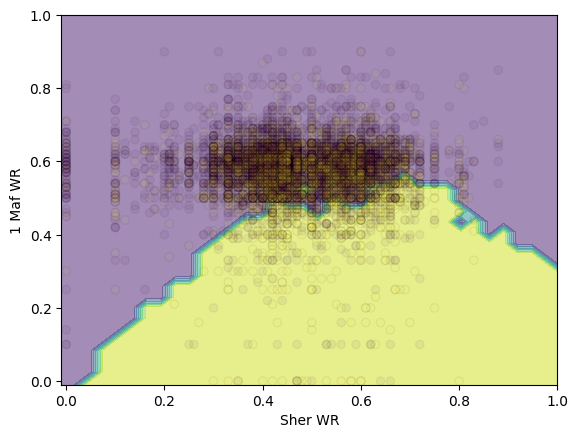

In [15]:
knn2d = KNeighborsClassifier(n_neighbors=k)
knn_model_2d = knn2d.fit(train_x[['Sher WR', '1 Maf WR']], train_y)
disp = DecisionBoundaryDisplay.from_estimator(knn_model_2d, train_x[['Sher WR', '1 Maf WR']], response_method="predict", alpha=0.5)
disp.ax_.scatter(train_x['Sher WR'], train_x['1 Maf WR'], c=train_y, edgecolor="k", alpha=0.05)
plt.xlim([-0.01, 1])
plt.ylim([-0.01, 1])
plt.show()